### predict the chances for a goal in the next minute

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsbombpy import sb
import utils as utils
import SoccermaticsForPython.FCPython as sfp_fcp
import SoccermaticsForPython as sfp
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn import metrics 
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import mlflow

pd.set_option('display.max_columns', None)

In [4]:
# Change this cell if you are not running a local tracking server!

mlflow.set_tracking_uri("http://localhost:8080")

In [46]:
experiment_name = 'goal-prediction'

In [47]:
mlflow.create_experiment(experiment_name)

'272374784026455757'

#### import dataset

In [48]:
df = pd.read_csv('../data/20231110train_dataset.csv', index_col=0)
df.set_index('uniekid', inplace=True)

In [49]:
df.head(1)

,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Chris Mepham,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,player_Daniel O''Shaughnessy,player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Francesco Ac

#### create train and testset + imbalanced metrics

In [50]:
# algemene train en testset
X = df.drop('goal', axis=1)
y = df['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [51]:
y_test.value_counts(normalize=True)

0    0.985915
1    0.014085
Name: goal, dtype: float64

In [52]:
# verschillende balaning technieken testen met verschillende strategy's

In [53]:
# strategies = np.linspace(0,1,10)    #1 = 50/50 distribution between 0 and 1 class, 0.5 = 66 (0) and 33 (1) distribution
# strategy = 0.25
# strategy = 0.5
# strategy = 0.75
strategy = 0.85
# strategy = 1

In [54]:
rus = RandomUnderSampler(random_state=0,sampling_strategy=strategy)    # remove 0 class
ros = RandomOverSampler(random_state =0, sampling_strategy=strategy)   # add copies 1 class
smote = SMOTE(random_state =0,sampling_strategy=strategy)              # add synthetic 1 class
sme = SMOTEENN(random_state=0, sampling_strategy=strategy)             # https://towardsdatascience.com/imbalanced-classification-in-python-smote-enn-method-db5db06b8d50

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smoteENN, y_train_smoteENN = sme.fit_resample(X_train, y_train)

In [55]:
y_train_rus.value_counts(normalize=True)  

0    0.539623
1    0.460377
Name: goal, dtype: float64

In [56]:
y_train_ros.value_counts(normalize=True)  

0    0.540554
1    0.459446
Name: goal, dtype: float64

In [57]:
y_train_smote.value_counts(normalize=True)

0    0.540554
1    0.459446
Name: goal, dtype: float64

In [58]:
y_train_smoteENN.value_counts(normalize=True)  

0    0.51082
1    0.48918
Name: goal, dtype: float64

In [59]:
X_train_tot = [X_train, X_train_rus, X_train_ros, X_train_smote,X_train_smoteENN]
y_train_tot = [y_train, y_train_rus, y_train_ros, y_train_smote, y_train_smoteENN]
sampling_technique = ['nothing', 'undersampling' ,'oversampling' , 'smote' , 'smoteENN']

#### create model and evaluate

In [60]:
mlflow.start_run()

<ActiveRun: >

In [61]:
models = []

models.append(("LogisticRegression",LogisticRegression(random_state=42)))
models.append(("SVC",SVC(random_state=42)))
models.append(("RandomForest",RandomForestClassifier(random_state=42)))
models.append(("BalancedBagging", BalancedBaggingClassifier(random_state=42)))
models.append(("BalancedRandom", BalancedRandomForestClassifier(max_depth=2, random_state=42)))

In [62]:
mlflow.set_tags(
    tags={
        "project": "goalpredictor",
        "strategy": strategy
    }
)

In [63]:
def create_confusion_matrix(mod, name, X_test, y_test):
    plot_confusion_matrix(mod, X_test, y_test)
    plt.savefig(f'correlation_plot_{name}.png')
    mlflow.log_artifact(f'correlation_plot_{name}.png')
    plt.show()
    
def roc_plot(mod, name):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, mod.predict_proba(X_test)[:,1])
    fig = plt.subplot()
    auc = metrics.roc_auc_score(y_test,mod.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_plot_{name}.png")
    mlflow.log_artifact(f"roc_plot_{name}.png")
    plt.show()

def precision_recall_plot(mod, name):
    precision, recall, _ = precision_recall_curve(y_test, mod.predict_proba(X_test)[:,1])
    plt.plot(recall, precision, marker='.', label=f'{name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(f"pc_plot_{name}.png")
    mlflow.log_artifact(f"pc_plot_{name}.png")    
    plt.show()    

Voor het volgende model:  LogisticRegression
Met in deze ronde de volgende sampling technique: nothing:


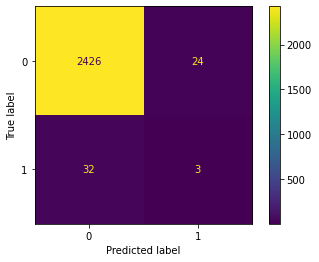

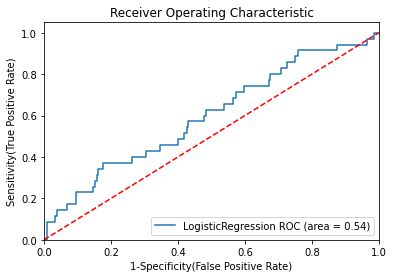

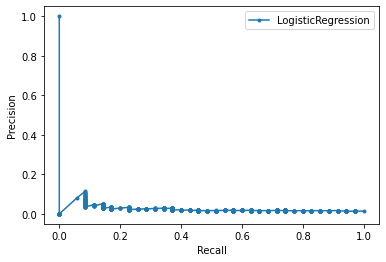

Voor het volgende model:  LogisticRegression
Met in deze ronde de volgende sampling technique: undersampling:


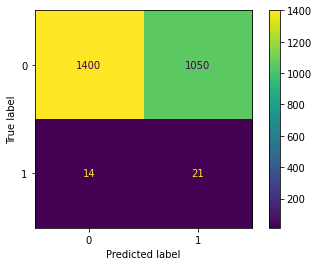

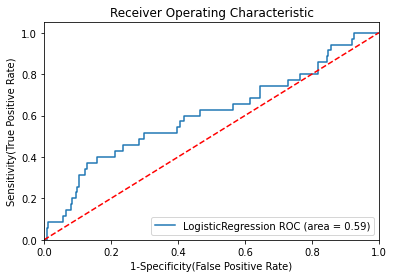

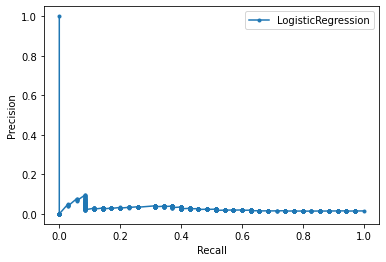

Voor het volgende model:  LogisticRegression
Met in deze ronde de volgende sampling technique: oversampling:


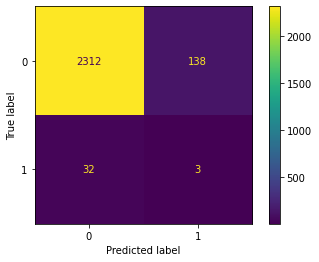

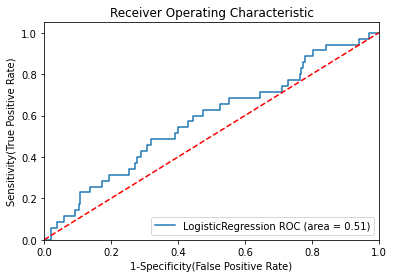

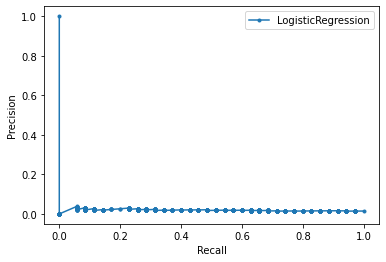

Voor het volgende model:  LogisticRegression
Met in deze ronde de volgende sampling technique: smote:


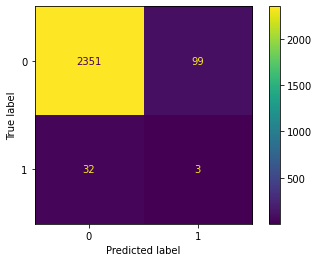

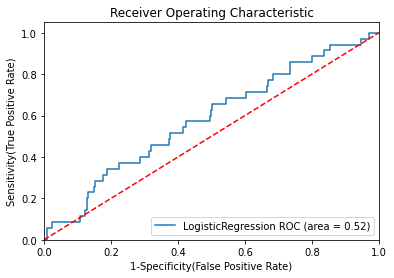

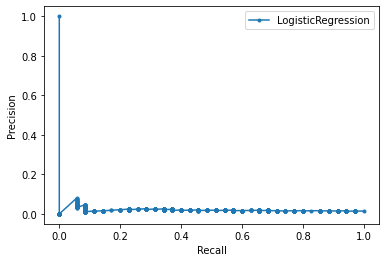

Voor het volgende model:  LogisticRegression
Met in deze ronde de volgende sampling technique: smoteENN:


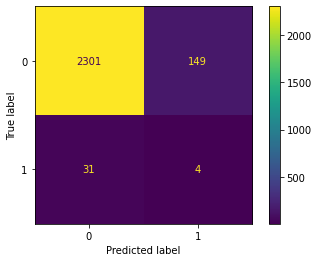

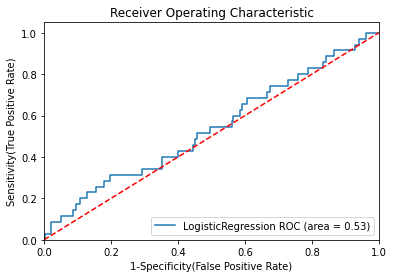

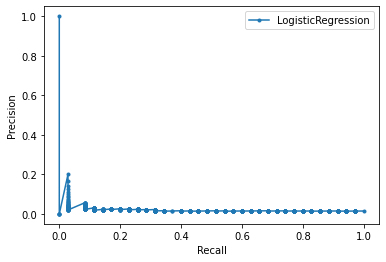

Voor het volgende model:  SVC
Met in deze ronde de volgende sampling technique: nothing:


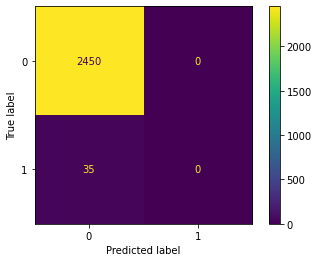

following combination is not working:  nothing SVC SVC(random_state=42)
following combination is not working:  nothing SVC SVC(random_state=42)
Voor het volgende model:  SVC
Met in deze ronde de volgende sampling technique: undersampling:


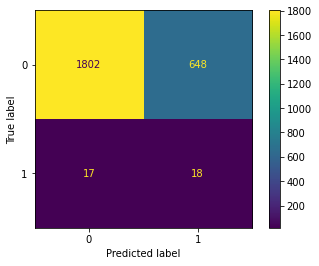

following combination is not working:  undersampling SVC SVC(random_state=42)
following combination is not working:  undersampling SVC SVC(random_state=42)
Voor het volgende model:  SVC
Met in deze ronde de volgende sampling technique: oversampling:


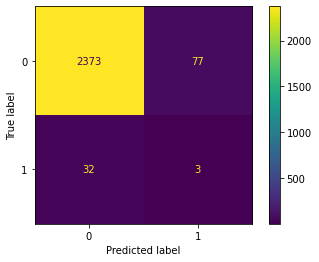

following combination is not working:  oversampling SVC SVC(random_state=42)
following combination is not working:  oversampling SVC SVC(random_state=42)
Voor het volgende model:  SVC
Met in deze ronde de volgende sampling technique: smote:


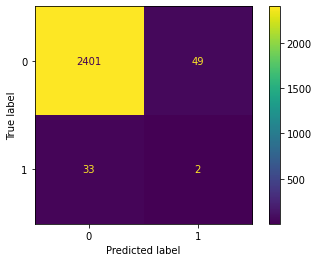

following combination is not working:  smote SVC SVC(random_state=42)
following combination is not working:  smote SVC SVC(random_state=42)
Voor het volgende model:  SVC
Met in deze ronde de volgende sampling technique: smoteENN:


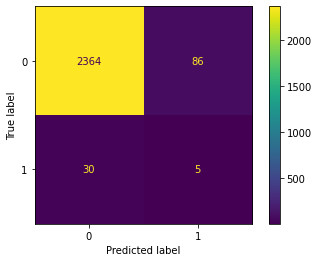

following combination is not working:  smoteENN SVC SVC(random_state=42)
following combination is not working:  smoteENN SVC SVC(random_state=42)
Voor het volgende model:  RandomForest
Met in deze ronde de volgende sampling technique: nothing:


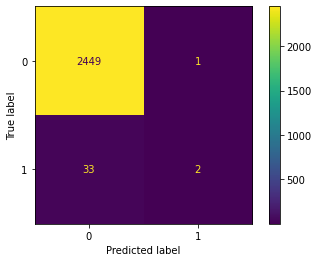

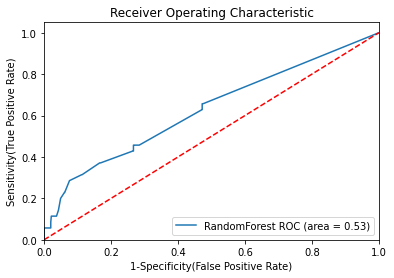

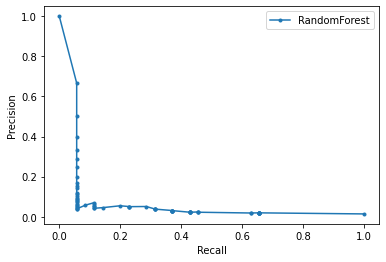

Voor het volgende model:  RandomForest
Met in deze ronde de volgende sampling technique: undersampling:


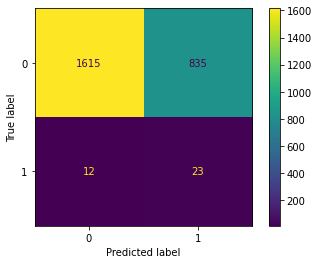

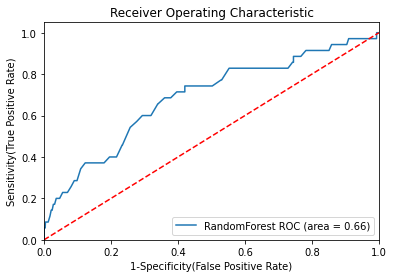

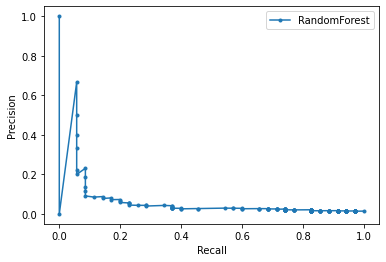

Voor het volgende model:  RandomForest
Met in deze ronde de volgende sampling technique: oversampling:


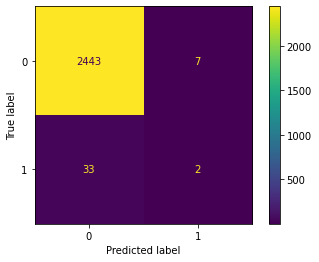

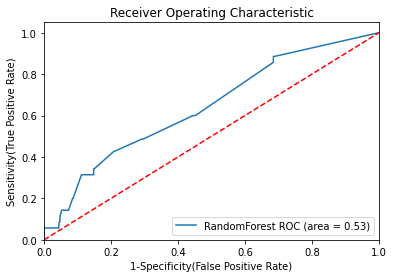

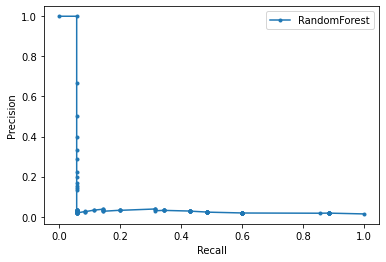

Voor het volgende model:  RandomForest
Met in deze ronde de volgende sampling technique: smote:


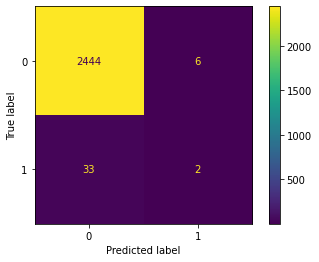

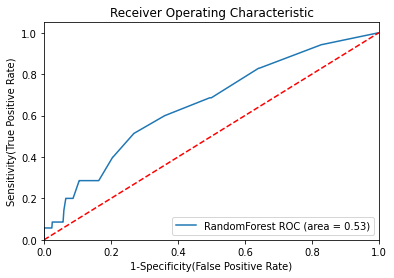

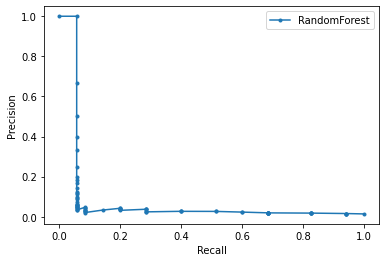

Voor het volgende model:  RandomForest
Met in deze ronde de volgende sampling technique: smoteENN:


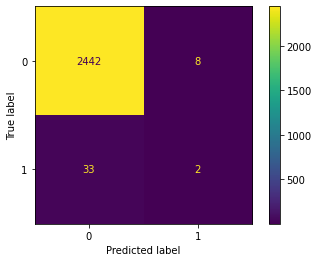

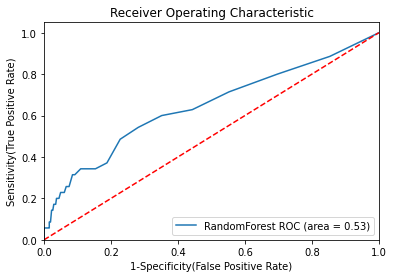

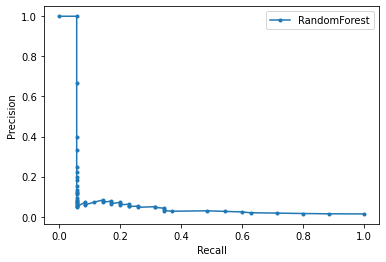

Voor het volgende model:  BalancedBagging
Met in deze ronde de volgende sampling technique: nothing:


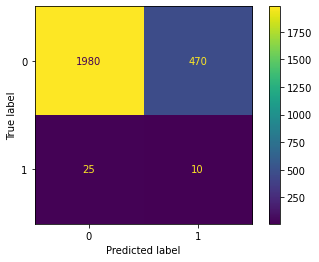

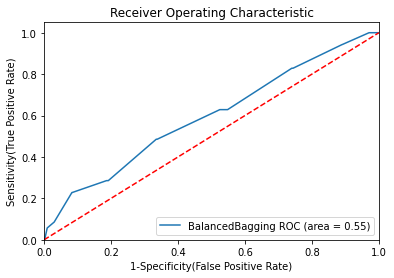

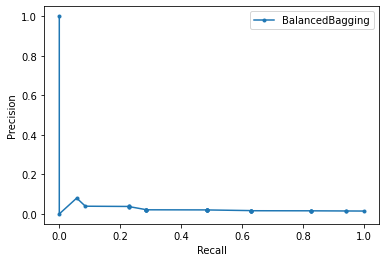

Voor het volgende model:  BalancedBagging
Met in deze ronde de volgende sampling technique: undersampling:


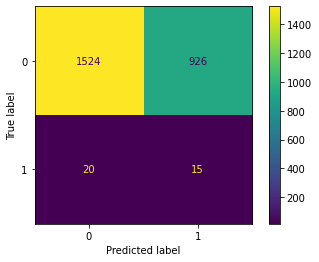

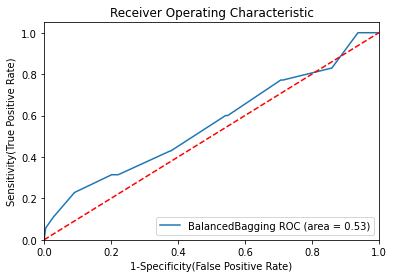

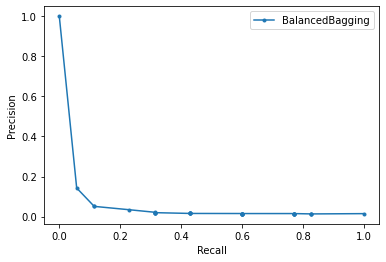

Voor het volgende model:  BalancedBagging
Met in deze ronde de volgende sampling technique: oversampling:


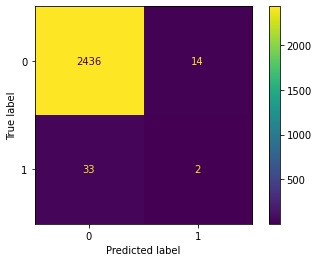

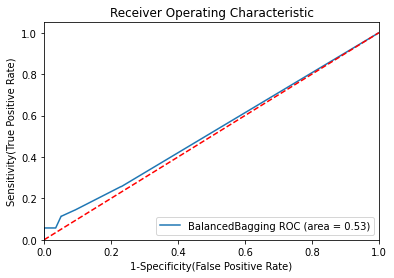

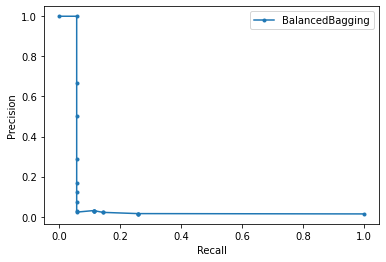

Voor het volgende model:  BalancedBagging
Met in deze ronde de volgende sampling technique: smote:


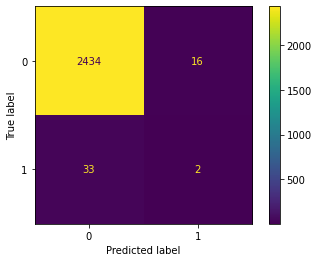

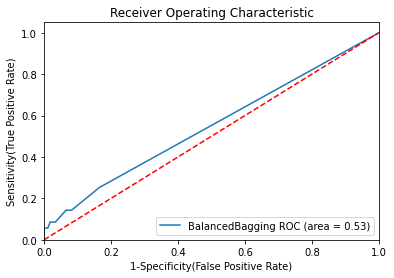

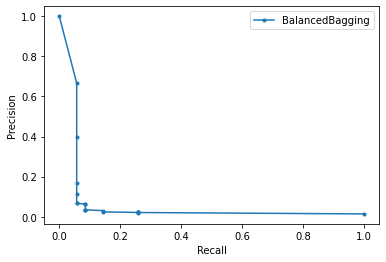

Voor het volgende model:  BalancedBagging
Met in deze ronde de volgende sampling technique: smoteENN:


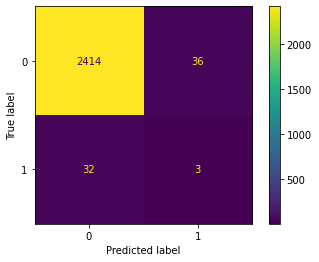

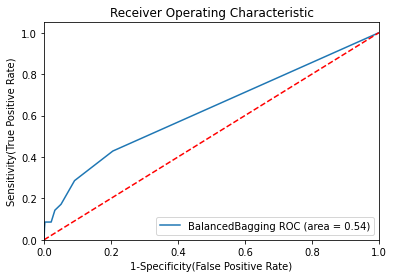

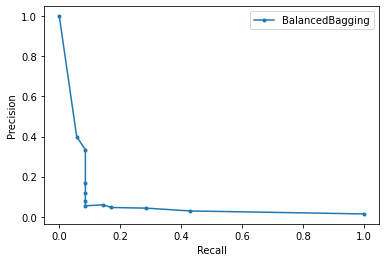

Voor het volgende model:  BalancedRandom
Met in deze ronde de volgende sampling technique: nothing:


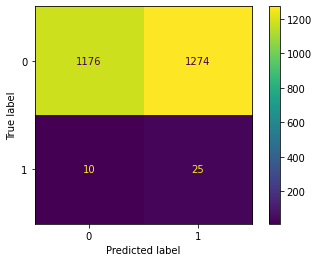

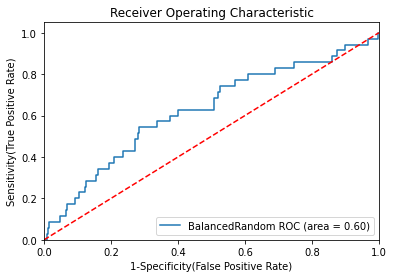

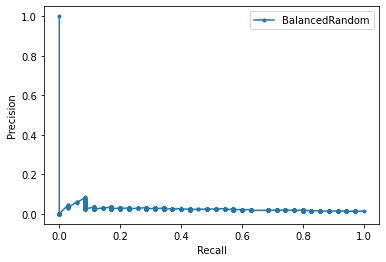

Voor het volgende model:  BalancedRandom
Met in deze ronde de volgende sampling technique: undersampling:


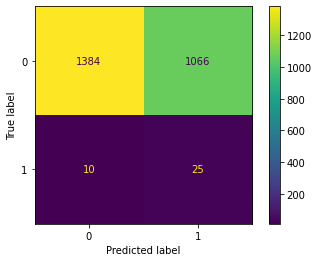

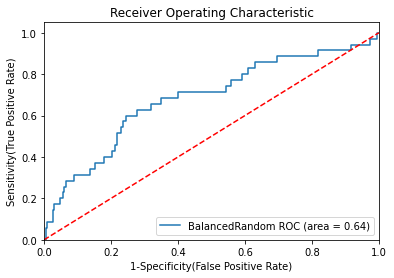

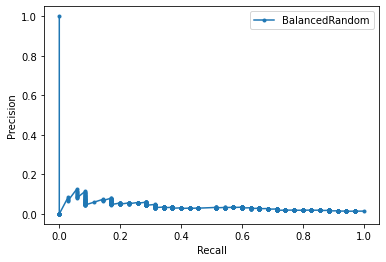

Voor het volgende model:  BalancedRandom
Met in deze ronde de volgende sampling technique: oversampling:


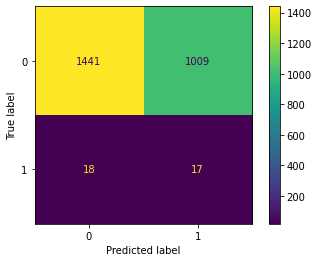

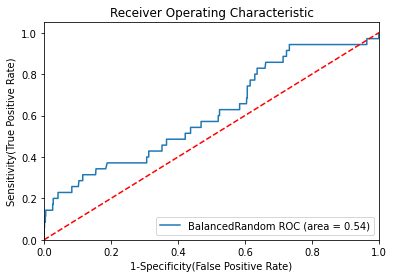

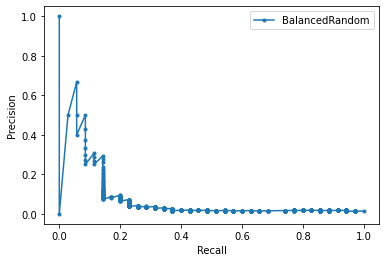

Voor het volgende model:  BalancedRandom
Met in deze ronde de volgende sampling technique: smote:


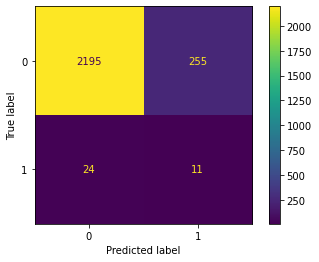

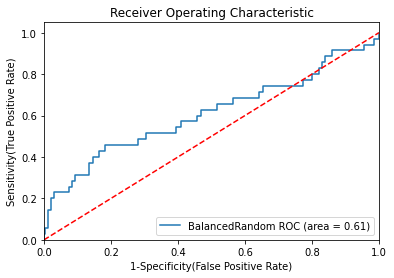

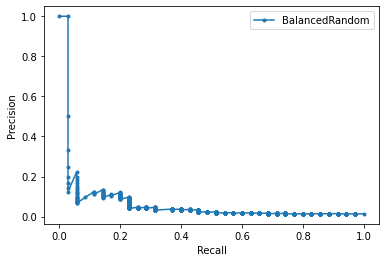

Voor het volgende model:  BalancedRandom
Met in deze ronde de volgende sampling technique: smoteENN:


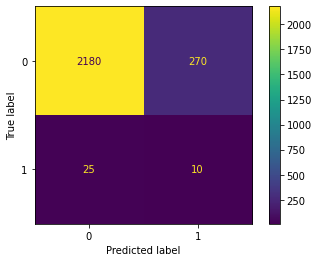

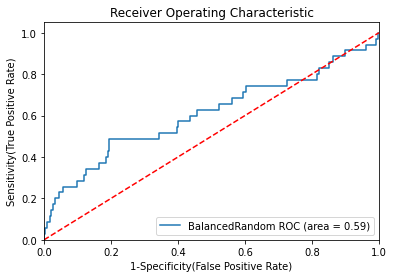

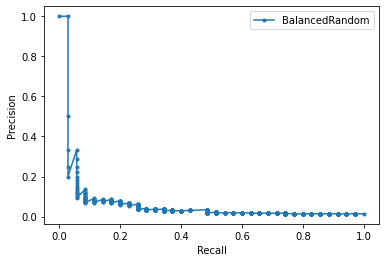

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
roc_score  = make_scorer(roc_auc_score)

results = []
techniques = []
names = []
train = []
models_trained = []

for name, model in models:
    for technique, x, y in zip(sampling_technique, X_train_tot, y_train_tot):
        mod = make_pipeline(StandardScaler(), model)
        # result = cross_val_score(mod, x, y, scoring=roc_score, cv=3)
        mod.fit(x, y)            
        result = metrics.roc_auc_score(y_test, mod.predict(X_test))
        mlflow.log_metric('roc_score', result)           # logs the metrics

        # save results
        names.append(name)
        results.append(result)
        models_trained.append(mod)
        techniques.append(technique)
        print('Voor het volgende model: ', name)
        print(f'Met in deze ronde de volgende sampling technique: {technique}:')

        # create confusion matrix
        create_confusion_matrix(mod, name, X_test, y_test) #create confusion matrix
        
        #create roc plot
        try:
            roc_plot(mod, name)
        except AttributeError:
            print('following combination is not working: ', technique, name, model)
            pass
        
        # create precision recall curve
        try:
            precision_recall_plot(mod, name)
        except AttributeError:
            print('following combination is not working: ', technique, name, model)
            pass

In [65]:
resultsdf = pd.DataFrame(
    {'name': names,
     'result': results,
     'model': models_trained,
     'techniques': techniques
    })

In [66]:
resultsdf.sort_values(by='result', ascending=False).head(10)

,name,result,model,techniques
11,RandomForest,0.658163,"(StandardScaler(), (DecisionTreeClassifier(max...",undersampling
21,BalancedRandom,0.639592,"(StandardScaler(), (DecisionTreeClassifier(max...",undersampling
6,SVC,0.624898,"(StandardScaler(), SVC(random_state=42))",undersampling
23,BalancedRandom,0.605102,"(StandardScaler(), (DecisionTreeClassifier(max...",smote
20,BalancedRandom,0.597143,"(StandardScaler(), (DecisionTreeClassifier(max...",nothing
24,BalancedRandom,0.587755,"(StandardScaler(), (DecisionTreeClassifier(max...",smoteENN
1,LogisticRegression,0.585714,"(StandardScaler(), LogisticRegression(random_s...",undersampling
9,SVC,0.553878,"(StandardScaler(), SVC(random_state=42))",smoteENN
15,BalancedBagging,0.546939,"(StandardScaler(), ((RandomUnderSampler(random...",nothing
0,LogisticRegression,0.537959,"(StandardScaler(), LogisticRegression(random_s...",nothing


In [67]:
## save the model

In [68]:
model = resultsdf['model'][0]
mlflow.sklearn.log_model(model, 
                         artifact_path ="model")

In [69]:
mlflow.end_run()

In [70]:
import joblib

joblib.dump(model, '../models/best_model.joblib')

['../models/best_model.joblib']

In [42]:
# # all roc curves together
# ax = plt.gca()
# for i in models_trained:
#     plot_roc_curve(i, X_test, y_test, ax=ax)